# **Project 5: Customer Segmentation with Clustering**

**Project Objective:** To use unsupervised machine learning to identify distinct groups of customers within a mall's dataset. By segmenting customers based on multiple dimensions (income, age, spending habits), we can provide rich, actionable insights to the marketing team for highly targeted campaigns.


#**Setup - Importing Libraries and Loading Data**

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import scipy.cluster.hierarchy as sch
from scipy import stats
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Set plot style
sns.set_style('whitegrid')

In [102]:
# Load the dataset from the user-provided file
!git clone "https://github.com/GeeksforgeeksDS/21-Days-21-Projects-Dataset"
data = pd.read_csv('/content/21-Days-21-Projects-Dataset/Datasets/Mall_Customers.csv')

print("Dataset loaded successfully.")
print(f"Data shape: {data.shape}")
data.head()

fatal: destination path '21-Days-21-Projects-Dataset' already exists and is not an empty directory.
Dataset loaded successfully.
Data shape: (200, 5)


,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


#**In-Depth Exploratory Data Analysis (EDA)**

In [104]:
# Drop the CustomerID as it's just an identifier and not useful for clustering
data.drop('CustomerID', axis=1, inplace=True)

In [105]:
print("\nDescriptive Statistics:")
data.describe()


Descriptive Statistics:


,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000
mean,38.850000,60.560000,50.200000
std,13.969007,26.264721,25.823522
min,18.000000,15.000000,1.000000
25%,28.750000,41.500000,34.750000
50%,36.000000,61.500000,50.000000
75%,49.000000,78.000000,73.000000
max,70.000000,137.000000,99.000000


In [106]:
data['Annual Income (k$)'].unique()

array([ 15,  16,  17,  18,  19,  20,  21,  23,  24,  25,  28,  29,  30,
        33,  34,  37,  38,  39,  40,  42,  43,  44,  46,  47,  48,  49,
        50,  54,  57,  58,  59,  60,  61,  62,  63,  64,  65,  67,  69,
        70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  81,  85,  86,
        87,  88,  93,  97,  98,  99, 101, 103, 113, 120, 126, 137])

In [107]:
data['Spending Score (1-100)'].unique()

array([39, 81,  6, 77, 40, 76, 94,  3, 72, 14, 99, 15, 13, 79, 35, 66, 29,
       98, 73,  5, 82, 32, 61, 31, 87,  4, 92, 17, 26, 75, 36, 28, 65, 55,
       47, 42, 52, 60, 54, 45, 41, 50, 46, 51, 56, 59, 48, 49, 53, 44, 57,
       58, 43, 91, 95, 11,  9, 34, 71, 88,  7, 10, 93, 12, 97, 74, 22, 90,
       20, 16, 89,  1, 78, 83, 27, 63, 86, 69, 24, 68, 85, 23,  8, 18])

In [108]:
data['Gender'].unique()

array(['Male', 'Female'], dtype=object)

#Feature Distributions

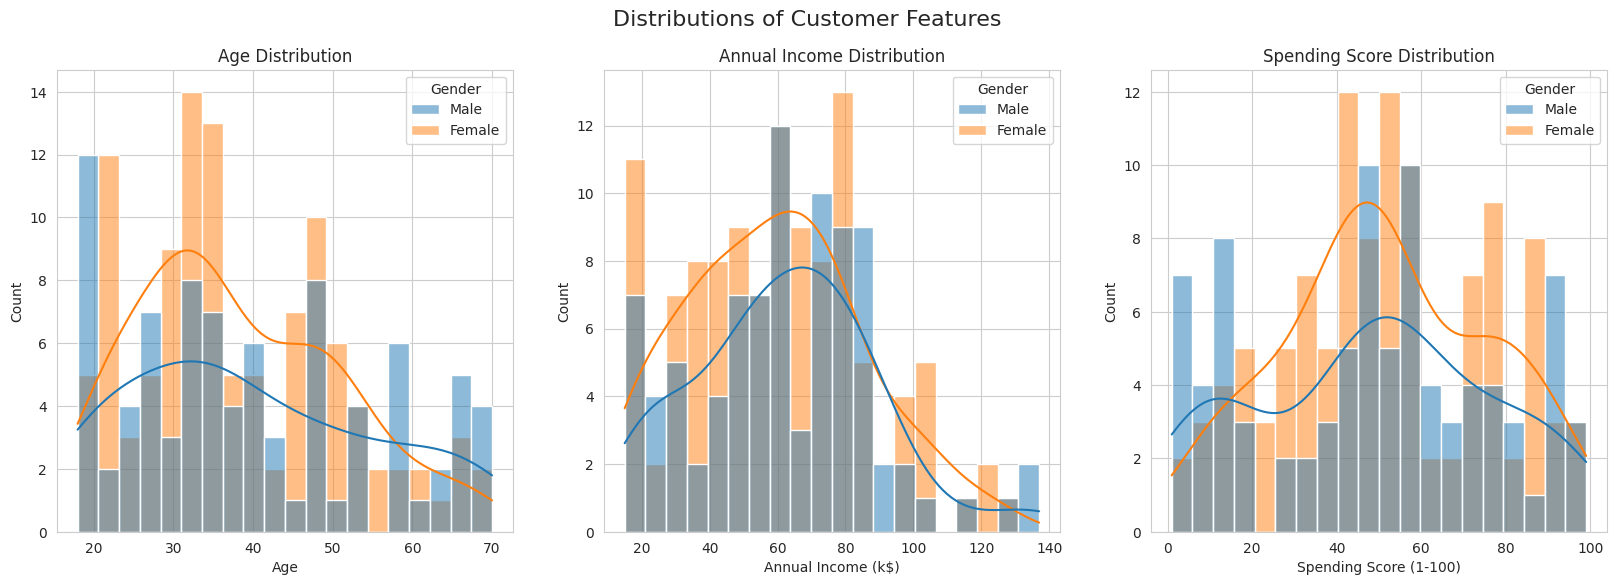

In [109]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distributions of Customer Features', fontsize=16)

sns.histplot(ax=axes[0], data=data, x='Age', kde=True, bins=20, hue='Gender').set_title('Age Distribution')
sns.histplot(ax=axes[1], data=data, x='Annual Income (k$)', kde=True, bins=20, hue='Gender').set_title('Annual Income Distribution')
sns.histplot(ax=axes[2], data=data, x='Spending Score (1-100)', kde=True, bins=20, hue='Gender').set_title('Spending Score Distribution')

plt.show()

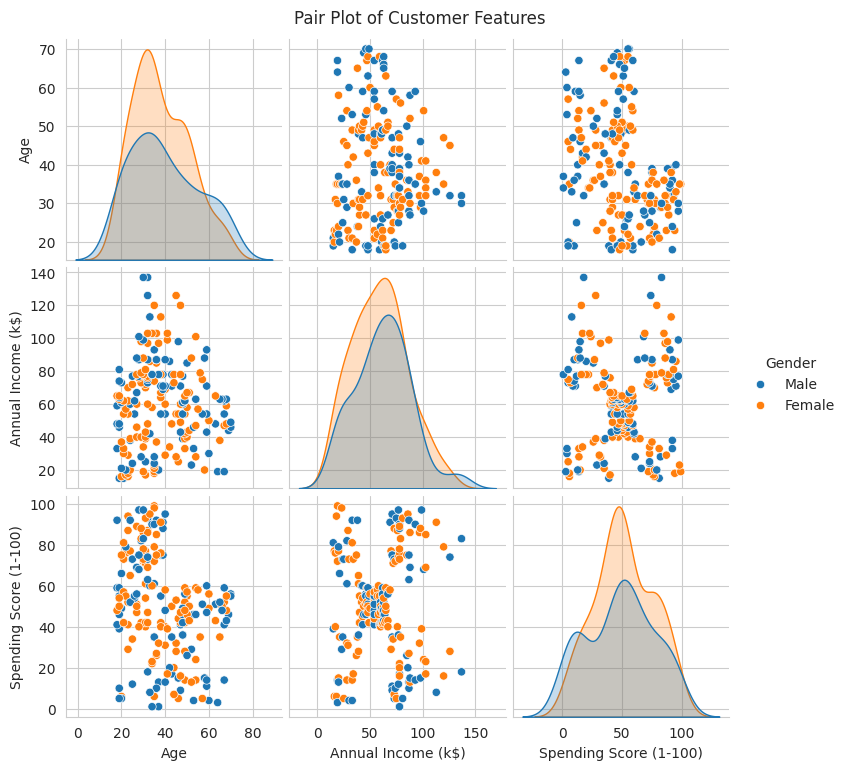

In [110]:
# Using pairplot to visualize relationships between all numerical variables
sns.pairplot(data, vars=['Age', 'Annual Income (k$)', 'Spending Score (1-100)'], hue='Gender', diag_kind='kde')
plt.suptitle('Pair Plot of Customer Features', y=1.02)
plt.show()

**CRITICAL INSIGHT from Pair Plot:**
- The **`Annual Income` vs. `Spending Score`** plot is the most revealing. It clearly shows distinct, blob-like groups, making it the perfect candidate for clustering.
- The **`Age` vs. `Spending Score`** plot shows some patterns but they are less defined. We see a concentration of high-spending customers in the younger age brackets.
- `Gender` does not appear to be a strong separating factor in any of these plots, as the distributions for males and females largely overlap.

In [111]:
#Let's visualize the three most important features together in an interactive 3D plot to see if the clusters hold up.
fig = px.scatter_3d(data,
                    x='Annual Income (k$)',
                    y='Spending Score (1-100)',
                    z='Age',
                    color='Gender',
                    title='3D View of Customer Data')
fig.show()

## **Theoretical Concept: The Elbow Method**

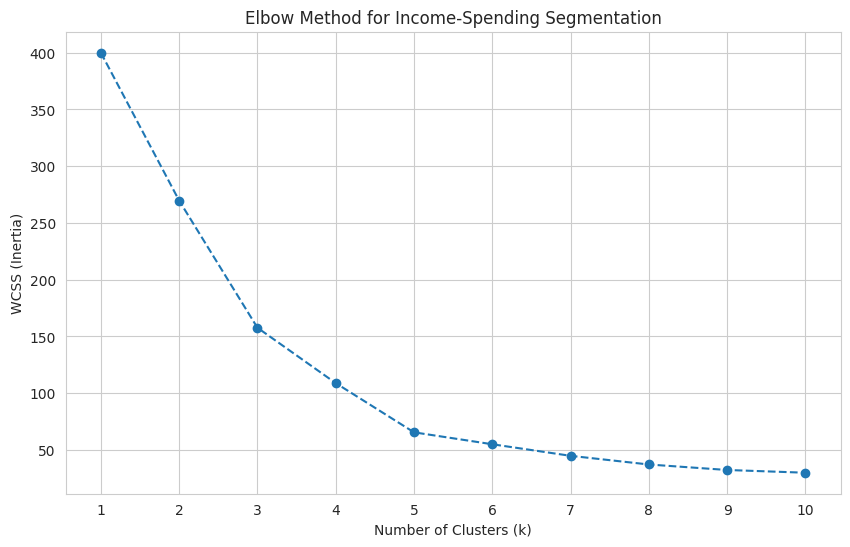

In [112]:
# 1. Select and scale the features
X1 = data[['Annual Income (k$)', 'Spending Score (1-100)']]
scaler1 = StandardScaler()
X1_scaled = scaler1.fit_transform(X1)

# 2. Implement the Elbow Method
wcss1 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X1_scaled)
    wcss1.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss1, marker='o', linestyle='--')
plt.title('Elbow Method for Income-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** The "elbow" of the curve is clearly at **k=5**. The WCSS decreases sharply until k=5, and then the rate of decrease flattens out. This confirms our visual intuition from the scatter plot!

In [113]:
# Build and fit the final model
kmeans1 = KMeans(n_clusters=5, init='k-means++', random_state=42, n_init=10)
data['Income_Cluster'] = kmeans1.fit_predict(X1_scaled)

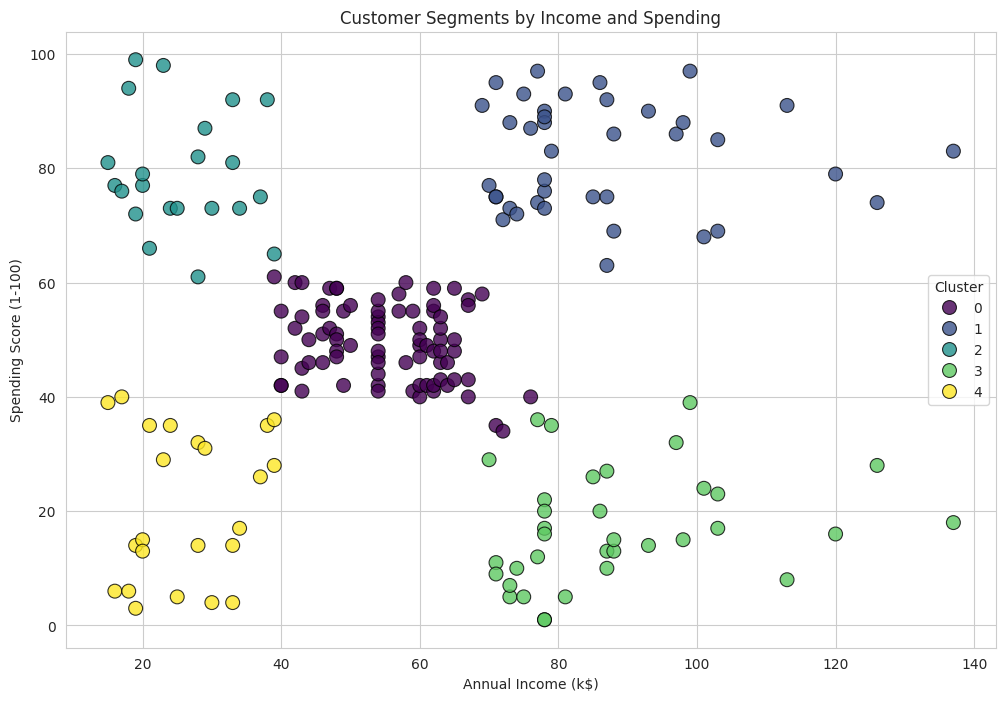

In [114]:
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='Annual Income (k$)', y='Spending Score (1-100)',
                hue='Income_Cluster', palette='viridis', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Income and Spending')
plt.legend(title='Cluster')
plt.show()

#**Using the quantitative profiles, we can define our segments:**
- **Cluster 0 (Careful High-Earners):** High income (88k) but low spending (17). Cautious, value-driven buyers.
- **Cluster 1 (Standard):** Average income (55k) and spending (50). This is the largest, core customer group.
- **Cluster 2 (Budget Shoppers):** Low income (26k) and low spending (21). Highly price-sensitive.
- **Cluster 3 (Target - High Value):** High income (87k) and high spending (82). The mall's prime target.
- **Cluster 4 (Enthusiasts):** Low income (26k) but high spending (79). Likely young, trend-focused shoppers.

In [115]:
# Quantitative Persona Analysis
cluster_profiles1 = data.groupby('Income_Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean().round(2)
cluster_profiles1['Size'] = data['Income_Cluster'].value_counts()
print("--- Income-Based Cluster Profiles ---")
cluster_profiles1

--- Income-Based Cluster Profiles ---


,Age,Annual Income (k$),Spending Score (1-100),Size
Income_Cluster,,,,
0,42.72,55.30,49.52,81
1,32.69,86.54,82.13,39
2,25.27,25.73,79.36,22
3,41.11,88.20,17.11,35
4,45.22,26.30,20.91,23


#**Age & Spending Score**

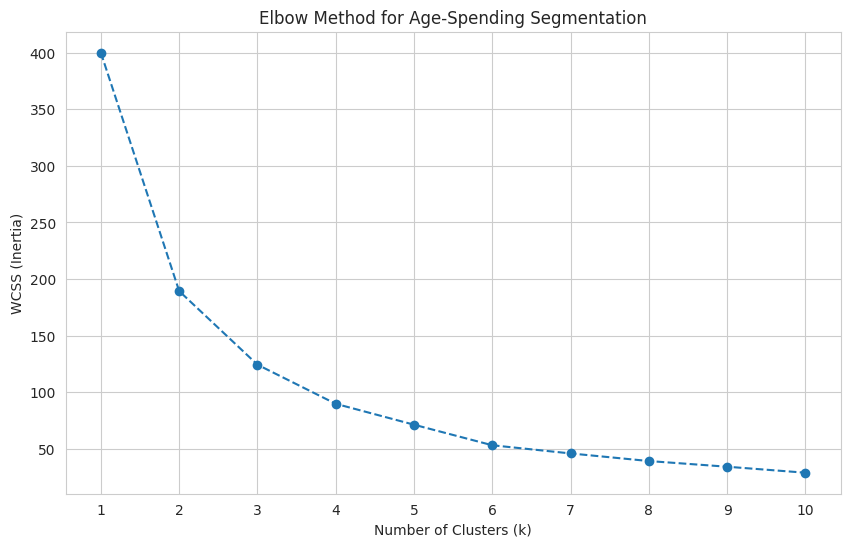

In [116]:
# 1. Select and scale the features
X2 = data[['Age', 'Spending Score (1-100)']]
scaler2 = StandardScaler()
X2_scaled = scaler2.fit_transform(X2)

# 2. Implement the Elbow Method
wcss2 = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X2_scaled)
    wcss2.append(kmeans.inertia_)

# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wcss2, marker='o', linestyle='--')
plt.title('Elbow Method for Age-Spending Segmentation')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Inertia)')
plt.xticks(range(1, 11))
plt.show()

**Observation:** The elbow is less sharp here, but **k=4** appears to be a reasonable choice.

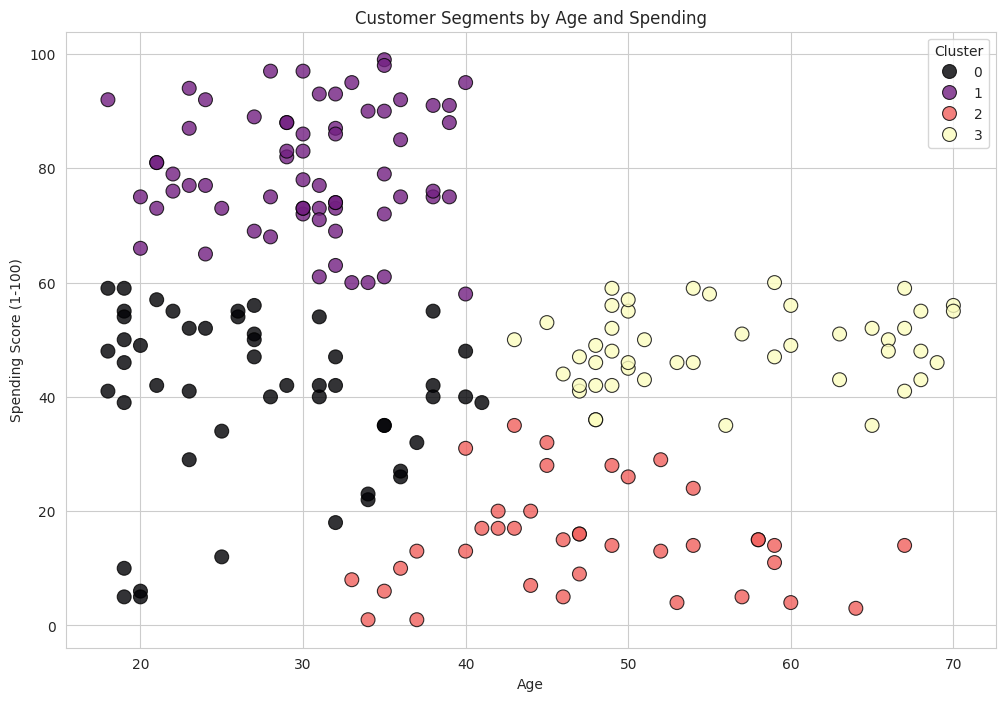

In [117]:
# Build and fit the final model for age segmentation
kmeans2 = KMeans(n_clusters=4, init='k-means++', random_state=42, n_init=10)
data['Age_Cluster'] = kmeans2.fit_predict(X2_scaled)

# Visualize the new clusters
plt.figure(figsize=(12, 8))
sns.scatterplot(data=data, x='Age', y='Spending Score (1-100)',
                hue='Age_Cluster', palette='magma', s=100, alpha=0.8, edgecolor='black')
plt.title('Customer Segments by Age and Spending')
plt.legend(title='Cluster')
plt.show()

##**This model gives us a different perspective:**
- **Young High-Spenders:** A clear group of customers under 40 with high spending scores.
- **Young Low-Spenders:** Customers under 40 with low-to-moderate spending.
- **Older Average-Spenders:** Customers over 40 with moderate spending scores.
- **Older Low-Spenders:** A small group of older customers with very low spending scores.

# **Theoretical Concept: Hierarchical Clustering & Dendrograms**
Unlike K-Means, Hierarchical Clustering doesn't require us to specify the number of clusters beforehand. It builds a tree-like hierarchy of clusters.

We can visualize this hierarchy with a **dendrogram**. The dendrogram shows how clusters are merged (or split). To find the optimal number of clusters, we look for the tallest vertical line that doesn't cross any horizontal lines and draw a horizontal line through it. The number of vertical lines our new line crosses is the optimal number of clusters.


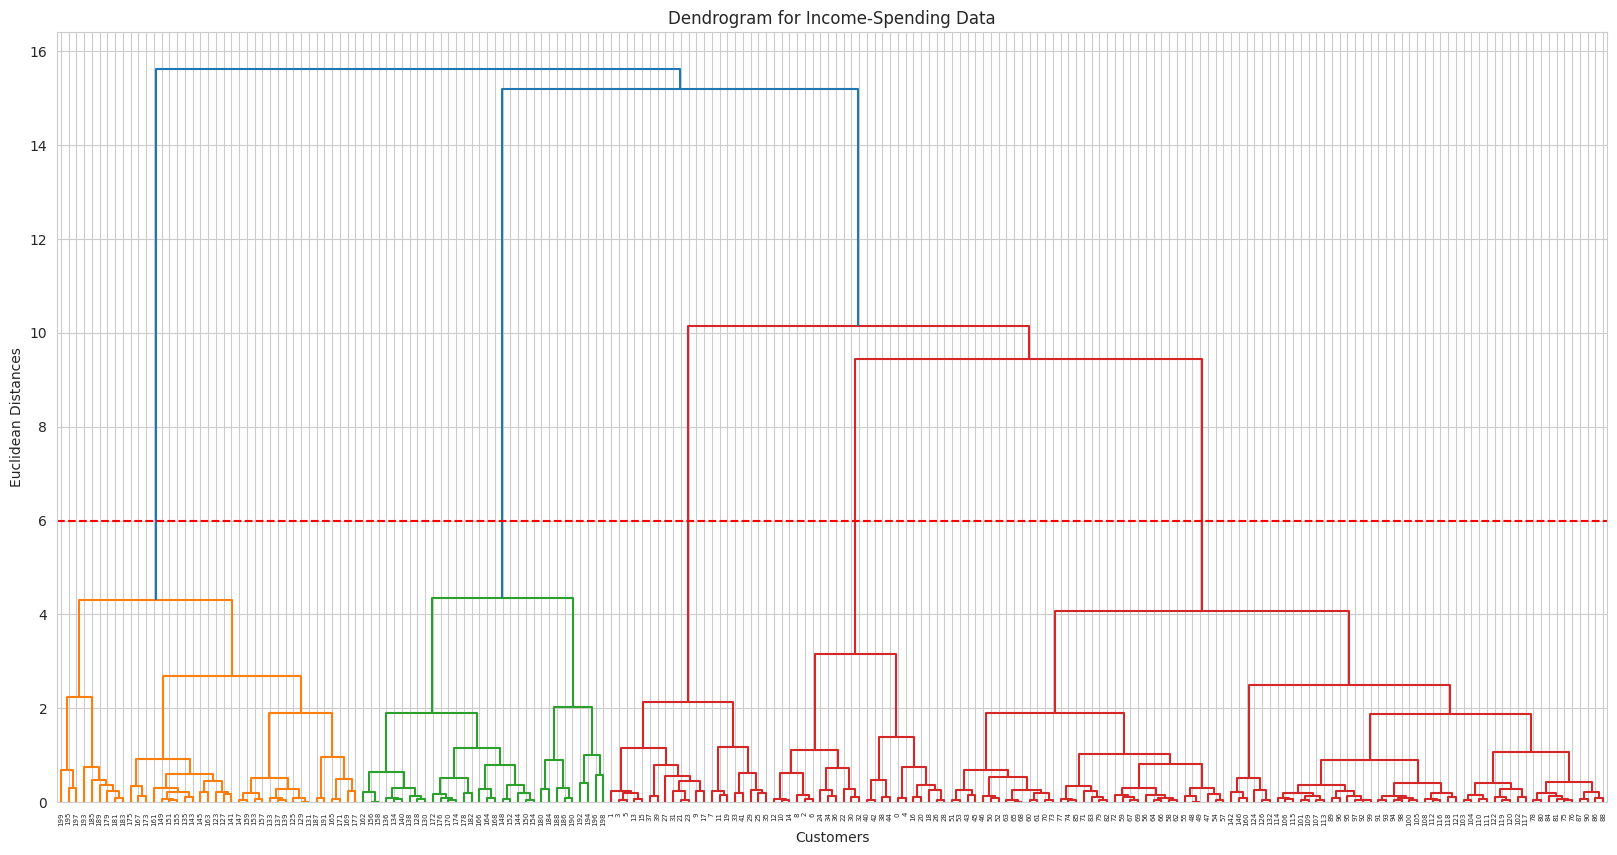

In [144]:
plt.figure(figsize=(20, 10))
dendrogram = sch.dendrogram(sch.linkage(X1_scaled, method='ward'))
plt.title('Dendrogram for Income-Spending Data')
plt.xlabel('Customers')
plt.ylabel('Euclidean Distances')
plt.axhline(y=6, color='r', linestyle='--') # Example cut-off line
plt.show()

**Insight:** The dendrogram also confirms that **5 clusters** is the optimal number for the income-spending data. If we draw a horizontal line at a height of 6 (as shown by the red dashed line), it crosses five vertical lines.

#**Gender VS. Spending Score**

In [119]:
# CONFIG: update these if your column names differ
GENDER_COL = "Gender"
SPEND_COL  = "Spending Score (1-100)"

In [120]:
# Basic hygiene
data = data.copy()
data = data.dropna(subset=[GENDER_COL, SPEND_COL])
data[GENDER_COL] = data[GENDER_COL].astype(str)

In [121]:
display(data[[GENDER_COL, SPEND_COL]].groupby(GENDER_COL).agg(
    count = (SPEND_COL, "size"),
    mean  = (SPEND_COL, "mean"),
    std   = (SPEND_COL, "std"),
    median= (SPEND_COL, "median"),
    q25   = (SPEND_COL, lambda s: np.quantile(s, 0.25)),
    q75   = (SPEND_COL, lambda s: np.quantile(s, 0.75)),
).round(2))

,count,mean,std,median,q25,q75
Gender,,,,,,
Female,112,51.53,24.11,50.0,35.0,73.0
Male,88,48.51,27.90,50.0,24.5,70.0


Female (n=112): mean 51.53, median 50, IQR 35–73, std 24.11.
Male (n=88): mean 48.51, median 50, IQR 24.5–70, std 27.90.
Takeaway: medians identical; means are close; spreads are similar—small practical difference.

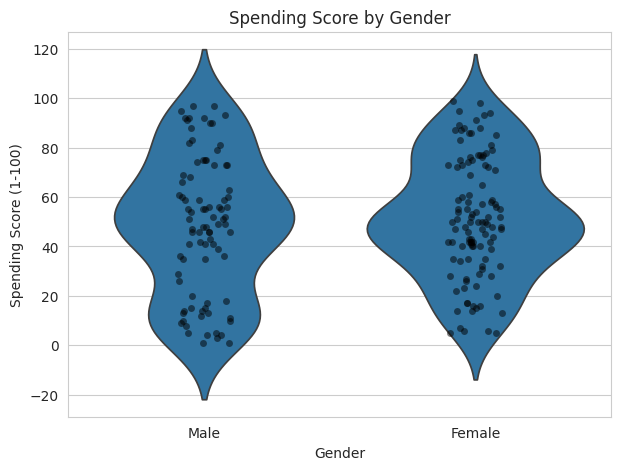

In [122]:
# Violin + strip
plt.figure(figsize=(7,5))
sns.violinplot(data=data, x=GENDER_COL, y=SPEND_COL, inner=None)
sns.stripplot(data=data, x=GENDER_COL, y=SPEND_COL, alpha=0.5, color="black")
plt.title("Spending Score by Gender")
plt.show()

##Spending Score by Gender (violin))
Shows the full distribution of Spending Score for males vs females. Both genders span almost the entire 0–100 range, with dense mass around 40–60. The two shapes largely overlap—no obvious separation by gender.

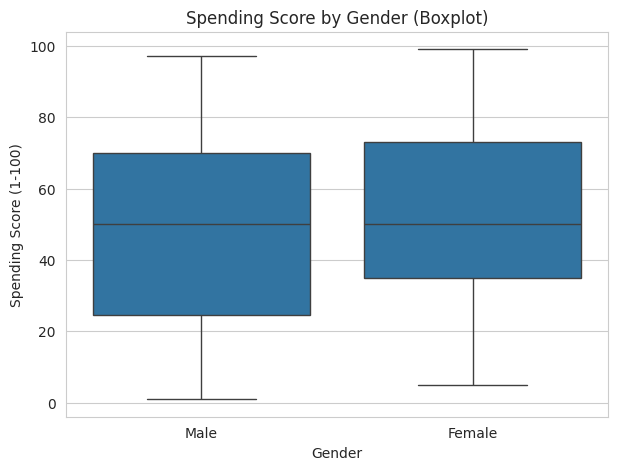

In [123]:
# Boxplot
plt.figure(figsize=(7,5))
sns.boxplot(data=data, x=GENDER_COL, y=SPEND_COL)
plt.title("Spending Score by Gender (Boxplot)")
plt.show()

##Boxplot for gender & SC
Both groups center at 50 with comparable IQRs (male 25–70, female 35–73) and similar outliers up to 100 and near 0. Distributions look alike.

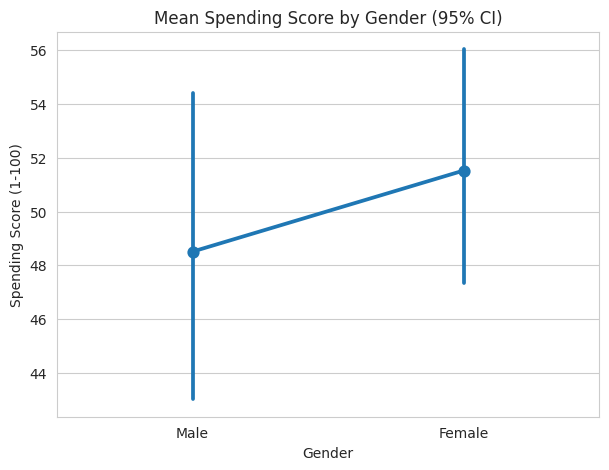

In [124]:
# Mean with 95% CI
plt.figure(figsize=(7,5))
sns.pointplot(data=data, x=GENDER_COL, y=SPEND_COL, errorbar=('ci', 95), dodge=True)
plt.title("Mean Spending Score by Gender (95% CI)")
plt.show()

###Female mean slightly above male, but the 95% confidence intervals overlap substantially. Visual message: no reliable mean difference.

In [125]:
# Significance test
groups = [g[SPEND_COL].values for _, g in data.groupby(GENDER_COL)]
if len(groups) == 2:
    t_stat, p_t = stats.ttest_ind(groups[0], groups[1], equal_var=False)  # Welch
    u_stat, p_u = stats.mannwhitneyu(groups[0], groups[1], alternative="two-sided")
    print(f"Welch t-test p-value: {p_t:.4f}")
    print(f"Mann–Whitney p-value: {p_u:.4f}")
else:
    f_stat, p_anova = stats.f_oneway(*groups)
    h_stat, p_kw = stats.kruskal(*groups)
    print(f"ANOVA p-value: {p_anova:.4f}")
    print(f"Kruskal–Wallis p-value: {p_kw:.4f}")

Welch t-test p-value: 0.4220
Mann–Whitney p-value: 0.5713


##Gender vs. Spending Score

Welch t-test p = 0.4220 and Mann–Whitney p = 0.5713 → differences are not statistically significant. Any gap is likely due to random variation.

###Gender does not meaningfully affect Spending Score in this dataset. Distributions overlap, group medians are identical, means differ only slightly, and statistical tests are non-significant.

###Gender is not a strong driver of spending in this dataset.

#**Feature Engineering + Clustering**

In [126]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [127]:
scaler = StandardScaler()
z_values = scaler.fit_transform(data[["Annual Income (k$)", "Spending Score (1-100)"]])
data[["z_income", "z_spend"]] = z_values

In [128]:
# Create Affinity Index = z_income + z_spend
data["Affinity_Index"] = data["z_income"] + data["z_spend"]

In [129]:
# Quick summary
print(data[["z_income", "z_spend", "Affinity_Index"]].describe())

           z_income       z_spend  Affinity_Index
count  2.000000e+02  2.000000e+02    2.000000e+02
mean  -2.131628e-16 -1.465494e-16   -2.131628e-16
std    1.002509e+00  1.002509e+00    1.424765e+00
min   -1.738999e+00 -1.910021e+00   -3.418699e+00
25%   -7.275093e-01 -5.997931e-01   -6.114626e-01
50%    3.587926e-02 -7.764312e-03   -1.769259e-01
75%    6.656748e-01  8.851316e-01    5.101238e-01
max    2.917671e+00  1.894492e+00    4.191018e+00


In [130]:
X = data[["Annual Income (k$)", "Spending Score (1-100)", "Affinity_Index"]]

In [134]:
inertias = []
K = range(2, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

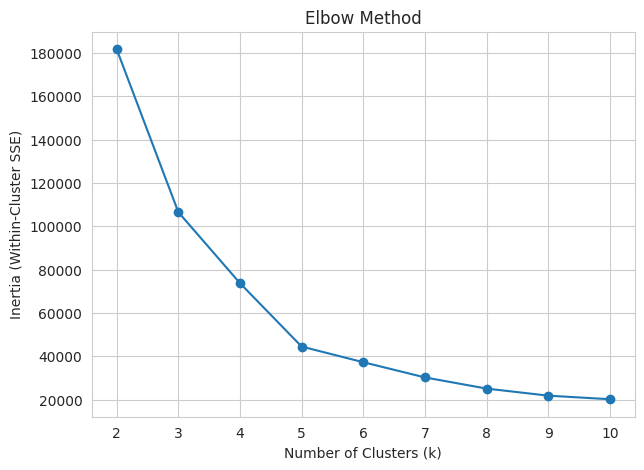

In [135]:
plt.figure(figsize=(7,5))
plt.plot(K, inertias, marker='o')
plt.title("Elbow Method")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Within-Cluster SSE)")
plt.show()

In [137]:
k_opt = 5
kmeans = KMeans(n_clusters=k_opt, n_init=10, random_state=42)
data["Cluster"] = kmeans.fit_predict(X)

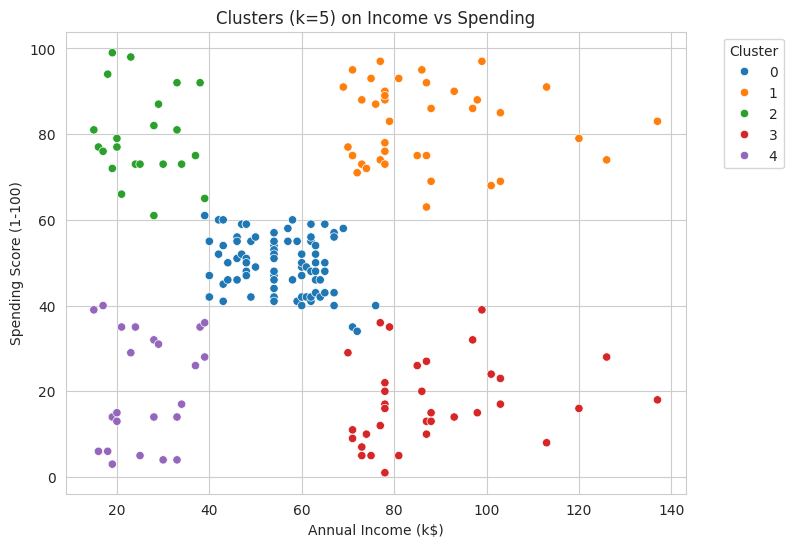

In [139]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    data=data,
    x="Annual Income (k$)",
    y="Spending Score (1-100)",
    hue="Cluster",
    palette="tab10"
)
plt.title(f"Clusters (k={k_opt}) on Income vs Spending")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.show()

In [141]:
cluster_summary = data.groupby("Cluster").agg(
    count=("Cluster", "size"),
    income_mean=("Annual Income (k$)", "mean"),
    spend_mean=("Spending Score (1-100)", "mean"),
    aff_idx_mean=("Affinity_Index", "mean"),
    age_mean=("Age", "mean")
).round(2)

print(cluster_summary)

         count  income_mean  spend_mean  aff_idx_mean  age_mean
Cluster                                                        
0           81        55.30       49.52         -0.23     42.72
1           39        86.54       82.13          2.23     32.69
2           22        25.73       79.36         -0.20     25.27
3           35        88.20       17.11         -0.23     41.11
4           23        26.30       20.91         -2.44     45.22


In [143]:
sil_score = silhouette_score(X, data["Cluster"])
print(f"Silhouette Score (k={k_opt}): {sil_score:.3f}")

Silhouette Score (k=5): 0.554


###Feature engineering: z-scores & affinity index

####A new affinity index was created by combining standardised values of income and spending. This index balances financial ability and spending behavior. It ranges from about -3.4 to +4.2, offering a useful feature for clustering that captures both traits at once.

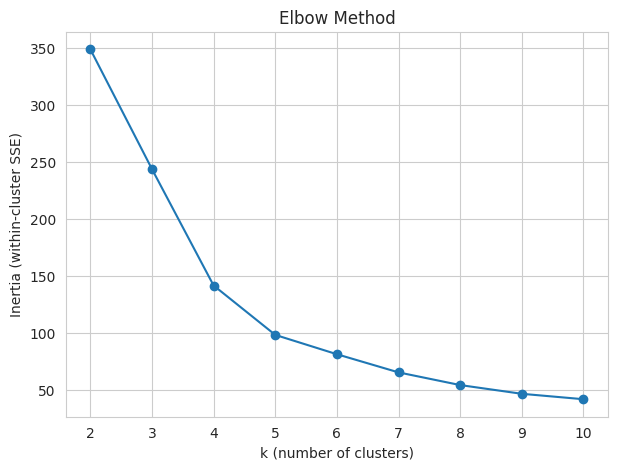

In [131]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

feats = data2[[INCOME_COL, SPEND_COL, "affinity_index"]].values

scaler_k = StandardScaler()
Xk = scaler_k.fit_transform(feats)

inertias = []
K = range(2, 11)
for k in K:
    km = KMeans(n_clusters=k, n_init=10, random_state=42)
    km.fit(Xk)
    inertias.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(K, inertias, marker="o")
plt.xticks(K)
plt.xlabel("k (number of clusters)")
plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Method")
plt.show()

####The Elbow Method shows a clear bend at k=5, confirming that five clusters is the best trade-off between simplicity and accuracy. Adding more clusters beyond five brings little improvement in variance reduction.

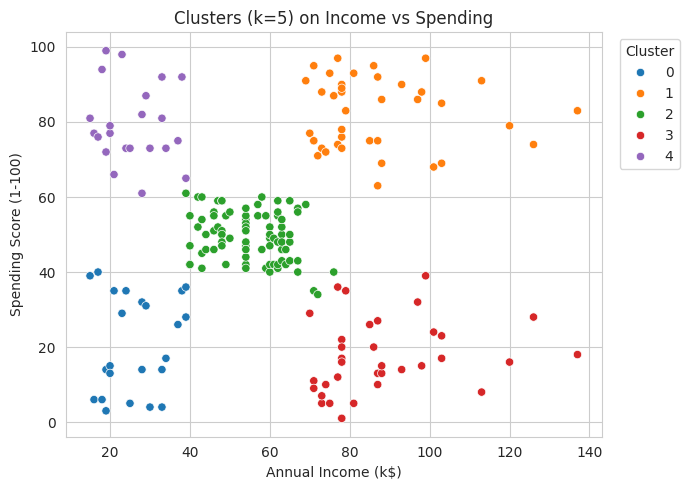

,n,income_mean,spend_mean,aff_idx_mean,age_mean
cluster,,,,,
1,39,86.54,82.13,2.23,32.69
4,22,25.73,79.36,-0.20,25.27
2,81,55.30,49.52,-0.23,42.72
0,23,26.30,20.91,-2.44,45.22
3,35,88.20,17.11,-0.23,41.11


In [132]:
# choose based on elbow
k_opt = 5  # <-- set after viewing the plot

kmeans = KMeans(n_clusters=k_opt, n_init=10, random_state=42)
labels = kmeans.fit_predict(Xk)
data2["cluster"] = labels

# Scatter: Income vs Spending
plt.figure(figsize=(7,5))
sns.scatterplot(data=data2, x=INCOME_COL, y=SPEND_COL, hue="cluster", palette="tab10")
plt.title(f"Clusters (k={k_opt}) on Income vs Spending")
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Cluster profiles
cluster_profile = data2.groupby("cluster").agg(
    n = ("cluster","size"),
    income_mean = (INCOME_COL,"mean"),
    spend_mean  = (SPEND_COL,"mean"),
    aff_idx_mean= ("affinity_index","mean"),
    age_mean    = ("Age","mean") if "Age" in data2.columns else (SPEND_COL, "mean")
).round(2)

display(cluster_profile.sort_values("spend_mean", ascending=False))

###The scatterplot shows five well-separated customer groups based on Annual Income and Spending Score. The cluster table gives clear profiles:

####Cluster 1: High income, high spending

####Cluster 4: Low income, high spending

####Cluster 2: Mid income, mid spending

####Cluster 0: Low income, low spending

####Cluster 3: High income, low spending


####This highlights distinct customer personas that can be targeted differently.

In [133]:
from sklearn.metrics import silhouette_score
sil = silhouette_score(Xk, labels)
print(f"Silhouette score (k={k_opt}): {sil:.3f}")

Silhouette score (k=5): 0.541


####The silhouette score of 0.541 indicates that the clusters are moderately strong and well-defined. This confirms that k=5 is a reasonable choice, as the clusters are both separated and internally consistent.

Feature Engineering & Gender Consideration

Initial analysis showed that gender does not significantly influence Spending Score (Welch t-test p=0.422; Mann–Whitney p=0.571). The distributions of male and female spending scores were nearly identical, suggesting that gender is not a useful predictor on its own.

To create a stronger basis for clustering, a new variable called the Affinity Index was engineered. This feature combines standardized Annual Income and Spending Score into a single measure:

Affinity Index
=
𝑧
(
Annual Income
)
+
𝑧
(
Spending Score)
Affinity Index=
z(Annual Income)+
z(Spending Score)

This captures both financial ability and spending behavior, providing a balanced indicator of customer engagement.

In [145]:
# --- Cluster profiling with gender distribution ---

cluster_profile = data.groupby("Cluster").agg(
    count=("Cluster", "size"),
    avg_income=("Annual Income (k$)", "mean"),
    avg_spend=("Spending Score (1-100)", "mean"),
    avg_affinity=("Affinity_Index", "mean"),
    avg_age=("Age", "mean")
).round(2)

# Add gender distribution (counts + %)
gender_dist = data.groupby(["Cluster", "Gender"]).size().unstack(fill_value=0)

# Add percentage per cluster
gender_pct = gender_dist.div(gender_dist.sum(axis=1), axis=0).round(2) * 100

# Merge into one table
cluster_summary = cluster_profile.join(gender_dist).join(gender_pct, rsuffix="_pct")

display(cluster_summary)


,count,avg_income,avg_spend,avg_affinity,avg_age,Female,Male,Female_pct,Male_pct
Cluster,,,,,,,,,
0,81,55.30,49.52,-0.23,42.72,48,33,59.0,41.0
1,39,86.54,82.13,2.23,32.69,21,18,54.0,46.0
2,22,25.73,79.36,-0.20,25.27,13,9,59.0,41.0
3,35,88.20,17.11,-0.23,41.11,16,19,46.0,54.0
4,23,26.30,20.91,-2.44,45.22,14,9,61.0,39.0
